# Process Web Json and Find Center claims

* Load Web Json file
* Extract claims and premises (data parsing)
* Find center claims

In [1]:
import json
import os

## Load web data and extract claims

In [2]:
from helper_function import count_valid_posts, get_claims
import numpy as np

In [3]:
with open('data/v3_70/Should-I-invest-in-Bitcoin_with_labels_v2_70.json', 'r') as f:
    json_content = json.load(f)
count_valid_posts(json_content)


(41, 70)

In [4]:
claims = get_claims(json_content)
print(f"get {len(claims)} claims")
claims

get 52 claims


['The “too late” mindset will ruin your investing\n\npsychology and your potential to make enough money to enjoy your life.',
 'Bitcoin is extremely weird',
 'The best time to buy bitcoin is when you understand it and see its value.',
 'Thinking about the assets you invest in over the long term helps reduce your stress levels.',
 'The worst way to invest as an everyday person is for the short term.',
 'If you must invest in it, remember the golden rule of investing - Never invest more than what you’re willing to lose. If you absolutely must, no more than 10% of your portfolio must be invested in risky assets.',
 'A “bubble” occurs when the price of a stock or investment is driven up to unsustainably high levels, substantially way more than what that item is worth. This bubble is usually caused by emotions of the masses, and not by logical investing or “looking at fundamentals”. And it always starts off as something that made sense in the beginning.\n\nIts exactly the same with Bitcoin.

## Sentiment Analysis

In [5]:
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

sentiment_model_path = 'pretrained_models/twitter-xlm-roberta-base-sentiment'
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_path)
sentiment_config = AutoConfig.from_pretrained(sentiment_model_path)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_path)


In [6]:
## get sentiment score for each sentence

preprocessed_claims = [preprocess(x) for x in claims]
sentiment_encodings = sentiment_tokenizer(preprocessed_claims, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    sentiment_output = sentiment_model(**sentiment_encodings)
sentiment_scores = sentiment_output.logits
sentiment_probability = F.softmax(sentiment_scores, dim=1).numpy()

## positive, neutral, negative
print(sentiment_config.id2label)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [7]:
## positive, neutral, negative
sentiment_probability[:5]

array([[0.8066722 , 0.16315508, 0.03017273],
       [0.91171026, 0.0704618 , 0.01782794],
       [0.02494254, 0.39772207, 0.57733536],
       [0.03428278, 0.35716414, 0.6085531 ],
       [0.8648083 , 0.11962221, 0.01556949]], dtype=float32)

## Get center claims

In [8]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [9]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('pretrained_models/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('pretrained_models/all-MiniLM-L6-v2')


In [10]:
encoded_input = tokenizer(claims, padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
# Normalization
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1).numpy()

In [11]:
sentence_embeddings = np.array(sentence_embeddings)
sentence_embeddings.shape

(52, 384)

In [12]:
### using PCA method to reduce demension and do visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Explained variance =  0.2529915049672127


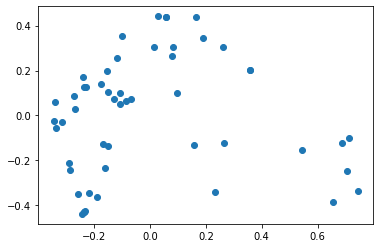

In [13]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(sentence_embeddings)
explained_variance = pca.explained_variance_ratio_
print("Explained variance = ",sum(explained_variance))
plt.scatter(x = x_pca.T[0], y=x_pca.T[1])
plt.show()

## Clustering

In [14]:
# clustering
from sklearn.cluster import SpectralClustering, AffinityPropagation

In [15]:
# use algorithms to reduce demension

pca = PCA()
sentence_embeddings_distilled = pca.fit_transform(sentence_embeddings)

In [16]:
# concate with sentiment scores
# decided not to use it
# sentence_embeddings_distilled = np.concatenate((sentence_embeddings_distilled, sentiment_probability), axis=1)
sentence_embeddings_distilled.shape

(52, 52)

In [17]:
cluster_algo = AffinityPropagation(random_state=43)
# cluster_algo = SpectralClustering(random_state=43, n_clusters=18)
# cluster = cluster_algo.fit(sentence_embeddings)
cluster = cluster_algo.fit(sentence_embeddings_distilled)
print("Clustered into {} clusters with labels {}".format(
    np.unique(cluster.labels_).shape, np.unique(cluster.labels_)))


Clustered into (12,) clusters with labels [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [18]:
unique, count = np.unique(cluster.labels_, return_counts=True)
print(dict(zip(*np.unique(cluster.labels_, return_counts=True))))


{0: 4, 1: 2, 2: 1, 3: 2, 4: 5, 5: 1, 6: 1, 7: 2, 8: 11, 9: 3, 10: 11, 11: 9}


In [19]:
claim_clusters = {i: [] for i in range(len(np.unique(cluster.labels_)))}
for i,label in enumerate(cluster.labels_):
    claim_clusters[label].append(claims[i])
claim_clusters

{0: ['The “too late” mindset will ruin your investing\n\npsychology and your potential to make enough money to enjoy your life.',
  'Obvious prospects for physical growth in an industry do not translate into obvious prospects for investors',
  'It’s not too late to invest.',
  'it’s not too late to invest.'],
 1: ['I would say YES!', 'The simple answer is Yes.'],
 2: ['That’s up to you.'],
 3: ['It depends what your level of disposable income is, how great your assets are, and what other assets you have invested in.',
  'It depends what your level of disposable income is, how great your assets are, and what other assets you have invested in.'],
 4: ['Bitcoin is extremely weird',
  'Bitcoins Are Scarce',
  'Bitcoins Are Useful',
  'Bitcoin is pretty useless. But so is gold.',
  'Bitcoin is pretty useless. But so is gold.'],
 5: ['Cryto currency is an extremely high-hazard venture, and CFDs bought on margin are significantly more hazardous.'],
 6: ['The significant thing is to do your ow

In [20]:
for i,term in enumerate(cluster.cluster_centers_indices_):
    print(f"{i}:\t{claims[term]}", end='\t')
    polarity_index = np.argmax(sentiment_probability[term])
    print(sentiment_config.id2label[polarity_index], sentiment_probability[term])

0:	It’s not too late to invest.	Neutral [0.08583032 0.5238266  0.39034304]
1:	I would say YES!	Positive [0.05781853 0.3563698  0.5858117 ]
2:	That’s up to you.	Neutral [0.12631425 0.62913644 0.24454932]
3:	It depends what your level of disposable income is, how great your assets are, and what other assets you have invested in.	Neutral [0.03835864 0.60064024 0.36100104]
4:	Bitcoin is pretty useless. But so is gold.	Negative [0.81395817 0.14981394 0.0362279 ]
5:	Cryto currency is an extremely high-hazard venture, and CFDs bought on margin are significantly more hazardous.	Negative [0.9103162  0.07403157 0.01565221]
6:	The significant thing is to do your own research and comprehend the dangers.	Neutral [0.20374432 0.59433293 0.20192268]
7:	It is almost certainly in a bubble.	Negative [0.67768466 0.28068125 0.04163409]
8:	Invest in Bitcoin, only if you are okay to loss all.	Neutral [0.123829   0.67485946 0.20131147]
9:	Of course you should	Positive [0.08770555 0.4093003  0.5029942 ]
10:	In

## Assign center claims

In [21]:
count = 0
for i in json_content['answers']:
    if i:
        for j in i['claim']:
            j['claimCenter'] = claims[cluster.labels_[count]]
            count += 1

In [22]:
with open('data/v3_70_filled/Should-I-invest-in-Bitcoin_with_labels_v3_70_filled.json', 'w') as f:
    json.dump(json_content, fp=f)